In [1]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

#### Notes: 
- Navigation axes: these describe where the data is measured. For a 4D-STEM dataset, this is typically the scan positions on the sample itself (x,y)
- Signal axes: these describe what is measured at each point. For 4D-STEM, this is usually the diffraction pattern, so 2D (kx, ky) at each scan position. 

In [57]:
# Load necessary libraries
import py4DSTEM
import hyperspy.api as hs
import numpy as np
import scipy
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology
from scipy.ndimage import shift

# Verify libraries
print("All libraries imported successfully!")

print(f"py4DSTEM version: {py4DSTEM.__version__}")
print(f"HyperSpy version: {hs.__version__}")

All libraries imported successfully!
py4DSTEM version: 0.14.16
HyperSpy version: 2.3.0


In [58]:
# Load dataset as HyperSpy signal
signal = hs.load("Si-SiGe.dm4")

# Inspect navigation and signal axes of dataset
print(signal.axes_manager)

<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


In [59]:
# (Re-)Define navigation and signal axes
signal.axes_manager.navigation_axes[0].name = "Rx" # real-space, horizontal axis
signal.axes_manager.navigation_axes[1].name = "Ry" # real-space, vertical axis

signal.axes_manager.signal_axes[0].name = "Qx" # reciprocal-space, horizontal axis
signal.axes_manager.signal_axes[1].name = "Qy" # reciprocal-space, vertical axis

# Verify updated navigation and signal axes
print(signal.axes_manager)

<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
              Rx |    448 |      0 |       0 |   0.062 |   1/nm 
              Ry |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              Qx |     17 |      0 |       0 |       2 |     nm 
              Qy |     77 |      0 |       0 |       2 |     nm 


In [60]:
# Verify dimensionality of the 4D-STEM dataset
print("Navigation dimensions:", signal.axes_manager.navigation_dimension)
print("Signal dimensions:", signal.axes_manager.signal_dimension)

Navigation dimensions: 2
Signal dimensions: 2


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [61]:
# Load as 4D-STEM dataset
filepath = "Si-SiGe.dm4"
dataset = py4DSTEM.io.import_file(filepath)

print("Dataset successfully loaded!")

# Load calibration dataset
filepath_calib = "Diffraction Si_Au_Calib.dm4"
dataset_calib = py4DSTEM.io.import_file(filepath_calib)

print("Calibration dataset successfully loaded!")

Dataset successfully loaded!
Calibration dataset successfully loaded!


In [65]:
# Inspect experimental dataset
print(type(dataset))
print("Dataset shape:", dataset.data.shape)
print(dataset.calibration)

# Inspect calibration dataset
print(type(dataset_calib))
print("Dataset shape:", dataset_calib.data.shape)
print(dataset_calib.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (480, 448, 77, 17)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)
<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (20, 20, 256, 256)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)


In [66]:
# Correct dataset axes (transposed)
dataset.data = np.transpose(dataset.data, (1, 0, 3, 2))
dataset.calibration.QR_flip = not dataset.calibration.QR_flip

print("Transposed axes (Rx, Ry, Qx, Qy):", dataset.data.shape)
print(dataset.calibration)


Transposed axes (Rx, Ry, Qx, Qy): (448, 480, 17, 77)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         True
)


In [67]:
# Set scan step size of experimental dataset using settings from calibration dataset
scan_step_size = 2.0393706 # nm 
reciprocal_step_size = 0.026740015 # A^-1

dataset.calibration.set_R_pixel_size(scan_step_size)
dataset.calibration.set_R_pixel_units("nm")
dataset.calibration.set_Q_pixel_size(reciprocal_step_size)
dataset.calibration.set_Q_pixel_units("A^-1")

# Verify new scan step size of experimental dataset
print("Scan step size set!")
print("(Verify) Calibrated dataset:", dataset.calibration)

Scan step size set!
(Verify) Calibrated dataset: Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    2.0393706
             Q_pixel_units:   A^-1
             R_pixel_units:   nm
             QR_flip:         True
)


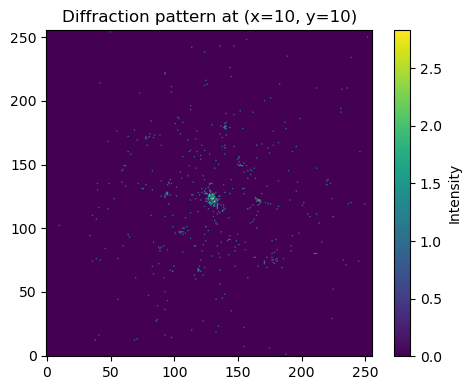

Calibration beam center: (130.16, 124.53)


In [68]:
# ----------------------------------------------- #
# Validate CoM correction on calibration dataset #
# ----------------------------------------------- #

# Choose representative scan position from calibration dataset
Rx0_calib = dataset_calib.data.shape[0] // 2
Ry0_calib = dataset_calib.data.shape[1] // 2

dp_calib = dataset_calib.data[Rx0_calib, Ry0_calib].astype(float)
plt.figure(figsize=(5, 4))
plt.imshow(np.sqrt(dp_calib), origin="lower") # sqrt to enhance contrast
plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0_calib}, y={Ry0_calib})")
plt.tight_layout()
plt.show()

# Average diffraction pattern over scan positions
dp_calib_avg = dataset_calib.data.mean(axis=(0, 1)).astype(float)

qy = np.arange(dp_calib_avg.shape[0])
qx = np.arange(dp_calib_avg.shape[1])
QX, QY = np.meshgrid(qx, qy)

I = dp_calib_avg.sum()
qx_calib = (QX * dp_calib_avg).sum() / I
qy_calib = (QY * dp_calib_avg).sum() / I

print(f"Calibration beam center: ({qx_calib:.2f}, {qy_calib:.2f})")

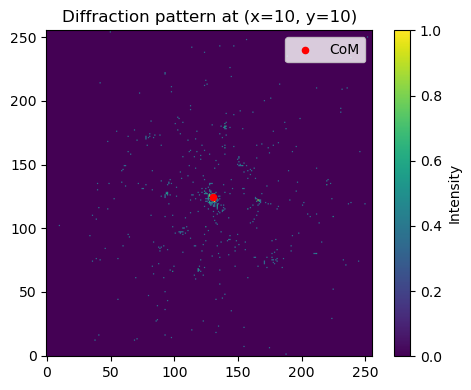

In [69]:
# Visualize CoM on diffraction pattern
plt.figure(figsize=(5, 4))
plt.imshow(np.sqrt(dp_calib), origin="lower") # sqrt to enhance contrast

com_x_calib = 130.16 # Geometric center at 128
com_y_calib = 124.53 # Geometric center at 128
plt.scatter(com_x_calib, com_y_calib, color='red',zorder=10, s=20, label='CoM')

plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0_calib}, y={Ry0_calib})")
plt.legend()
plt.tight_layout()
plt.show()

Using scan position: (224, 240)


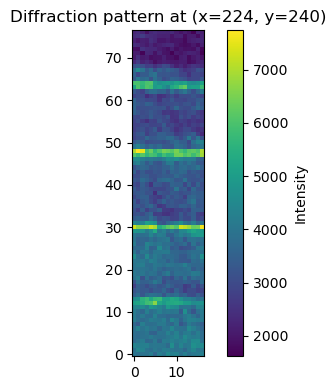

Experimental CoM: (7.93, 35.34)


In [84]:
# ----------------------------------------------- #
# Perform CoM correction on experimental dataset #
# ----------------------------------------------- #

# Choose representative scan position for experimental data
Rx0 = dataset.data.shape[0] // 2
Ry0 = dataset.data.shape[1] // 2

print("Using scan position:", (Rx0, Ry0))
dp = dataset.data[Rx0, Ry0].astype(float)
dp = dp.T

plt.figure(figsize=(5, 4))
plt.imshow(dp, origin="lower")
plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0}, y={Ry0})")
plt.tight_layout()
plt.show()

# Compute CoM from selected scan position
Qy, Qx = dp.shape 

qy = np.arange(Qy)[:, None]   # vertical
qx = np.arange(Qx)[None, :]   # horizontal

I = dp.sum()

qx_exp = (qx * dp).sum() / I
qy_exp = (qy * dp).sum() / I

print(f"Experimental CoM: ({qx_exp:.2f}, {qy_exp:.2f})")

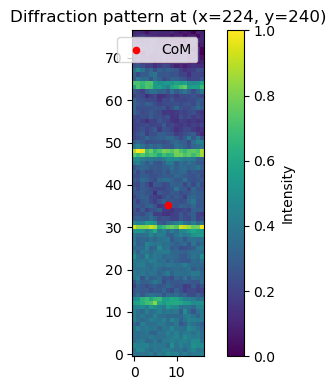

In [85]:
# Visualize CoM on diffraction pattern
plt.figure(figsize=(5, 4))
plt.imshow(dp, origin="lower")

com_x = 7.93 # Geometric center at 8.5
com_y = 35.34 # Geometric center at 38.5
plt.scatter(com_x, com_y, color='red',zorder=10, s=20, label='CoM')

plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0}, y={Ry0})")
plt.legend()
plt.tight_layout()
plt.show()

In [130]:
# Define CoM correction
Qy, Qx = dp.shape

print("Dataset shape:", dataset.data.shape)

qx_com = 7.93
qy_com = 35.34

qx_target = Qx / 2 # Geometric center
qy_target = Qy / 2 # Geometric center

print("Geometric center:", qx_target, qy_target)

dx = qx_target - qx_com # Shift along the Qx axis
dy = qy_target - qy_com # Shift along the Qy axis

print(f"Applying CoM shifts: dx = {dx:.2f}, dy = {dy:.2f}")

Dataset shape: (448, 480, 17, 77)
Geometric center: 8.5 38.5
Applying CoM shifts: dx = 0.57, dy = 3.16


In [131]:
import numpy as np
from scipy.ndimage import fourier_shift
from numpy.fft import fftn, ifftn

# Fourier shift to dataset (to preserve edges better)
dp_fft = fftn(dp)
dp_fft_shifted = fourier_shift(dp_fft, shift=(dy, dx)) 
dp_shifted_fft = ifftn(dp_fft_shifted).real

print("CoM shift applied using Fourier shift.")

CoM shift applied using Fourier shift.


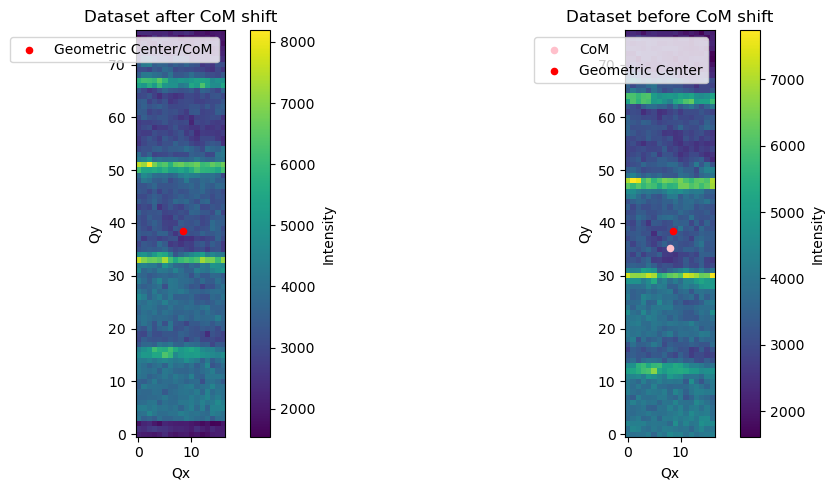

In [132]:
# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # side-by-side plots

# ========== Shifted dataset ==========
axes[0].imshow(dp_shifted_fft, origin='lower', cmap='viridis')
center_x = 8.5
center_y = 38.5
axes[0].scatter(center_x, center_y, color='red', zorder=10, s=20, label='Geometric Center/CoM')
axes[0].set_title('Dataset after CoM shift')
axes[0].set_xlabel('Qx')
axes[0].set_ylabel('Qy')
axes[0].legend()
fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04, label='Intensity')

# ========== Original dataset ==========
axes[1].imshow(dp, origin='lower', cmap='viridis')
com_x = 7.93
com_y = 35.34
axes[1].scatter(com_x, com_y, color='pink', zorder=10, s=20, label='CoM')
axes[1].scatter(center_x, center_y, color='red', zorder=10, s=20, label='Geometric Center')
axes[1].set_title('Dataset before CoM shift')
axes[1].set_xlabel('Qx')
axes[1].set_ylabel('Qy')
axes[1].legend()
fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04, label='Intensity')

plt.tight_layout()
plt.show()

In [133]:
# Apply shifts to dataset
dp_shifted = shift(dp, shift=(dy, dx), order=3) # cubic interpolation

print("CoM shift applied to dataset.")

CoM shift applied to dataset.


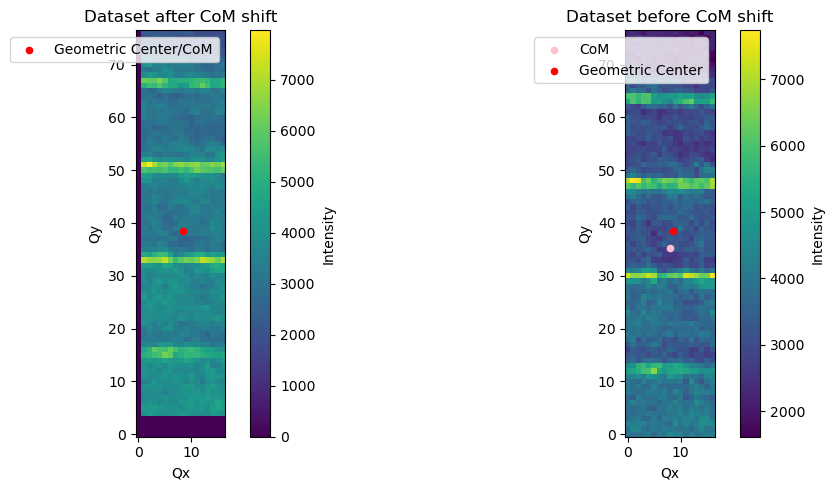

In [134]:
# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # side-by-side plots

# ========== Shifted dataset ==========
axes[0].imshow(dp_shifted, origin='lower', cmap='viridis')
center_x = 8.5
center_y = 38.5
axes[0].scatter(center_x, center_y, color='red', zorder=10, s=20, label='Geometric Center/CoM')
axes[0].set_title('Dataset after CoM shift')
axes[0].set_xlabel('Qx')
axes[0].set_ylabel('Qy')
axes[0].legend()
fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04, label='Intensity')

# ========== Original dataset ==========
axes[1].imshow(dp, origin='lower', cmap='viridis')
com_x = 7.93
com_y = 35.34
axes[1].scatter(com_x, com_y, color='pink', zorder=10, s=20, label='CoM')
axes[1].scatter(center_x, center_y, color='red', zorder=10, s=20, label='Geometric Center')
axes[1].set_title('Dataset before CoM shift')
axes[1].set_xlabel('Qx')
axes[1].set_ylabel('Qy')
axes[1].legend()
fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04, label='Intensity')

plt.tight_layout()
plt.show()

## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

#### Notes: 
- Bright Field (BF): sensitive to diffraction contrast, strain, crystal orientation; contrast arises from redistribution of intensity; not monotonic with atomic number
- Annular Dark Field (ADF): sensitive to high-angle scattering; produces a Z-contrast that scales with intensity

## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

In [ ]:
# Your code here




from matplotlib.patches import Rectangle
if scale_bar_pixels < adf_image.shape[1] - 5:
    # Position scale bar in bottom-left corner
    bar_x, bar_y = 2, adf_image.shape[0] - 4
    scale_bar = Rectangle((bar_x, bar_y), scale_bar_pixels, 1, fill=True, color='white', linewidth=1)
    ax.add_patch(scale_bar)
    ax.text(bar_x + scale_bar_pixels/2, bar_y - 1, f'{scale_bar_length} nm', ha='center', va='top', 
            color='white', fontsize=10, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.savefig('virtual_adf_figure_sisige.png', dpi=300, bbox_inches='tight')
plt.show()

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

## Notes
Virtual detectors are software-defined regions in a diffraction pattern that you can integrate over to form images. Because you record the full diffraction pattern at every probe position in a 4D-STEM experiment, you can choose any shape, size, or position of detector after the experiment -- this is called post-acquisition imaging.

- You can generate bright-field, dark-field, annular, or complex contrast images from the same dataset without changing the microscope.
- This flexibility allows you to extract multiple types of contrast (diffraction, Z-contrast, phase contrast) from a single scan

Essentially, the dataset contains all the scattering information, and virtual detectors let you "look at it" in whichever way you want after the experiment is done